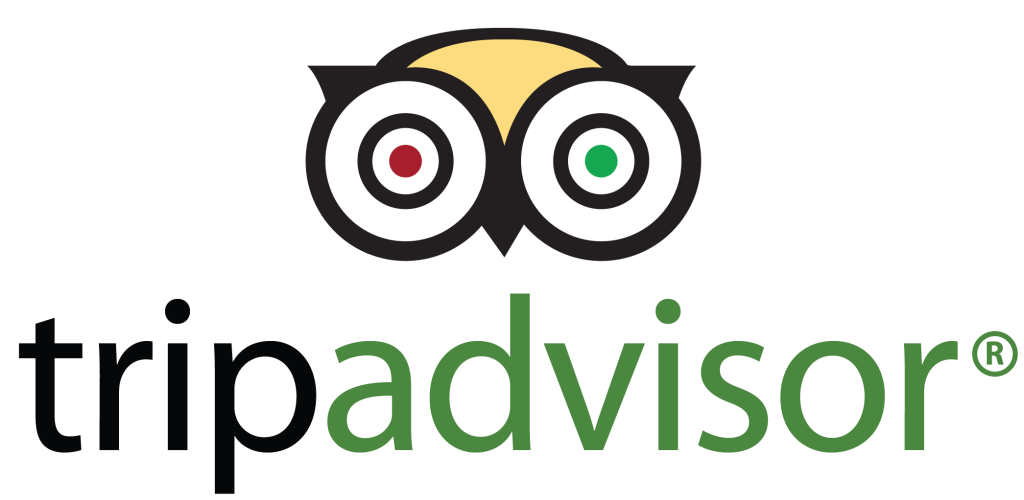

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tripadvisor — крупнейшая в мире платформа о путешествиях*[1], ежемесячно помогает 463 миллионам путешественников**[2] делать каждую поездку незабываемой. Путешественники по всему миру используют сайт и приложение Tripadvisor для того, чтобы просмотреть более чем 859 миллионов отзывов и комментариев о 8,6 миллионах вариантов жилья, ресторанов, развлечений, авиалиний и круизов. На этапе планирования и во время самой поездки путешественники обращаются к Tripadvisor для сравнения низких цен на отели, авиарейсы и круизы, бронирования популярных экскурсий, в том числе и по знаменитым достопримечательностям, а также резервирования столиков в хороших ресторанах. Tripadvisor, незаменимый помощник для путешественников, доступен в 49 регионах мира на 28 языках.

Нам предствлены данные о 40 тысячах ресторанов из разных городов мира. Есть гипотеза о том, что некоторые рестораны завышают себе оценку на TripAdvisor и тем самым вводят клиентов в заблуждение.  Наша задача создать модель, которая могла бы делать прогноз оценки ресторана на основе различной информации о нем

Для начала работы нам необходимо импортировать библиотеку Pandas и загрузить данный нам объем данных о ресторанах

In [2]:
import pandas as pd
df = pd.read_csv('main_task.csv')

Приведем наименования столбцов к одному формату для удобства работы с ними

In [3]:
df = df.rename(columns={"Restaurant_id": "restaurant_id", "City": "city", "Ranking": "rank", "Rating": 'rating', "Number of Reviews": "number_of_reviews",
                        "Reviews": "reviews", "URL_TA": "url_ta", "ID_TA": "id_ta", "Price Range": "price_range", "Cuisine Style": "cuisine"})

Заполним пропуски

In [4]:
df['cuisine'] = df['cuisine'].fillna('Other')
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)

На данный момент информация о кухнях, отзывах представлена в формате String, с которым нам неудобно работать.
Разделим данные о кухнях, отзывы, даты на отдельные списки и приведем к необходимому формату

Кухни:

In [5]:
def to_list(cuisine):
    cuisine = cuisine.replace("'", "")
    cuisine = cuisine.replace("[", "")
    cuisine = cuisine.replace("]", "")
    cuisine = cuisine.split(', ')
    return cuisine


df['cuisine'] = df['cuisine'].apply(to_list)

Отзывы и даты
Для этого нам понадобится библиотека from datetime

In [6]:
from datetime import datetime, timedelta


def split_date_review(review):
    review = review[1:-1]
    review = review.split('], [')
    return review


def delete_extra_simbols(review):
    new_list = []
    for i in review:
        i = i.replace('[', '')
        i = i.replace(']', '')
        i = i.replace('"', '')
        i = i.replace("'", '')
        new_list.append(i)
    return new_list


df['reviews'] = df['reviews'].apply(split_date_review)
df['reviews'] = df['reviews'].apply(delete_extra_simbols)
df['reviews_dates'] = df['reviews'].apply(lambda x: x[1])
df['reviews_dates'] = df['reviews_dates'].apply(lambda x: x.split(', '))
df['reviews_comments'] = df['reviews'].apply(lambda x: x[0])
df['reviews_comments'] = df['reviews_comments'].apply(lambda x: x.split(', '))


def to_date_format(date):
    date_list = []
    for i in date:
        if len(i) > 0:
            i = datetime.strptime(i, '%m/%d/%Y')
            date_list.append(i)
        else:
            continue
    return date_list


df['reviews_dates'] = df['reviews_dates'].apply(to_date_format)

#### Feature Engineering 
На основании текущих признаков и их представления мы не сможем создать модель.
Нам необходимо преобразовать признаки для того, чтобы наша модель могла с ними работать.
И самое главное - добавить новые, которые по нашей гипотезе могли бы повысить точность модели

Посчитаем количество представленных кухонь в ресторане, предполагая, что их количество можеть влиять на оценку ресторана

In [7]:
df['cuisune_number'] = df['cuisine'].apply(lambda x: len(x))

Разницу в днях между отзывами. Вероятно время работы ресторана, его опыт могут отразиться на финальной оценке

In [8]:
def diff_between_dates(list_of_dates):
    diff = 0
    list_of_dates = sorted(list_of_dates)
    if len(list_of_dates) > 0:
        d1 = list_of_dates[0]
        for i in list_of_dates[1:]:
            diff = i - d1
            diff = diff.days
            d1 = i
    else:
        diff = 0
    return diff


df['days_between_review_dates'] = df['reviews_dates'].apply(diff_between_dates)

Добавляем признак городов.  Предполагаем, что в какие-то города в целом более интересны своей местной кухней, что может сказаться на оценке

In [9]:
cities = []


def get_list_of_cities(city):
    if city in cities:
        city_item = city
    else:
        cities.append(city)
        city_item = city
    return city_item


df['city'] = df['city'].apply(get_list_of_cities)
df = df.reindex(columns=df.columns.tolist() + cities)
for i in cities:
    df[i] = df[i].fillna(0)


def check_city(city):
    if item in city:
        return 1
    return 0


for item in cities:
    df[item] = df['city'].apply(check_city)

В сети есть доступная информация о туристическом потом по городам.  Как правило, туристы чаще всего пользуются порталом TripAdvisor и оставляют там оценки.  Используем эти данные для нашей модели

In [10]:
tourists_arrivals = pd.read_csv('tourists_arrivals.csv', sep =';')
tourists_arrivals = tourists_arrivals.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],  axis = 1)
tourists_arrivals = tourists_arrivals.dropna()
tourists_arrivals['city'] = tourists_arrivals['city'].apply(lambda x: x.lower())
df['city'] = df['city'].apply(lambda x: x.lower())
df = df.merge(tourists_arrivals, on = 'city', how = 'left')

Приведем показатель разброса цена к численному показателю

In [11]:
prices = {}


def get_price(price):
    if price in prices:
        prices[price] += 1
    else:
        prices[price] = 1
    return price


df['price_range'] = df['price_range'].apply(get_price)


def price_level(price):
    if price == '$$ - $$$':
        return 3
    elif price == '$$$$':
        return 4
    elif price == '$':
        return 1
    else:
        return None


df['price_level'] = df['price_range'].apply(price_level)

Для некоторых ресторанов у нас отсутствует информация о диапозоне цен.  Заполним её медианным значением

In [12]:
median_price = df['price_level'].median()
df['price_level'] = df['price_level'].fillna(median_price)

Составим график для понимания в какой ценовой диапозон чаще всего попадают наши рестораны

In [13]:
df['price_level'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Количество посетителей по дням')

Очищаем отзывв от лишних символов для дальнейшей работы со строковыми значениями

In [14]:
import re
import string


def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def clean_reviews_text(review_list):
    cleaned_list = []
    for i in review_list:
        i = text_clean(i)
        cleaned_list.append(i)
    return cleaned_list


def cleaned(x): return text_clean(x)


df['reviews_cleaned_comments'] = df['reviews_comments'].apply(
    clean_reviews_text)

Отзывы оказывают наибольшее влияние на фильную оценку ресторана, поэтому нам очень важно правильно их интерпретировать
В Python есть готовая библиотека sentifish, которая на вход получает слова из отзывов и возвращает уровень "положительности" слов. Таким образом мы можем понять на сколько отзыв положительный или отрицательный в числовом выражении
Применяем библиотеку sentifish для обработки отзывов в положительные или отрицательные значения в зависимости от эмоционального контекста слова

In [15]:
! pip install sentifish
from sentifish import Sentiment


def sentimet_value(reviews):
    new_list = []
    for i in reviews:
        x = Sentiment(i)
        try:
            polarity = x.analyze()
        except:
            polarity = 0
        if polarity == 0:
            continue
        else:
            new_list.append(polarity)
    return new_list


df['reviews_cleaned_values'] = df['reviews_cleaned_comments'].apply(
    sentimet_value)

Посчитаем среднюю оценку отзывов по ресторану

In [16]:
def mean_values(list_values):
    if len(list_values) == 0:
        result = 0
    else:
        result = sum(list_values)/len(list_values)
    return result


df['reviews_cleaned_values_mean'] = df['reviews_cleaned_values'].apply(
    mean_values)

Удаляем лишние показатели

In [17]:
new_df = df.drop(['restaurant_id', 'city', 'cuisine', 'reviews_comments', 'price_range', 'reviews', 'url_ta', 'price_range',
                  'reviews', 'url_ta', 'id_ta', 'reviews_dates', 'reviews_cleaned_comments', 'reviews_cleaned_values'],  axis=1)

Проведем корреляционный анализ, исключив города, для того, чтобы понять как признаки влияют друг на друга и может быть исключить те, которые сильно коррелируют

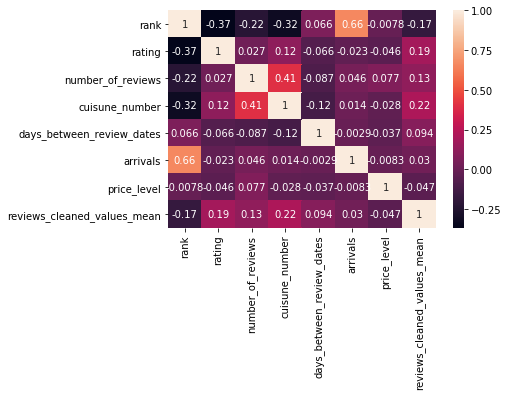

In [36]:
import seaborn as sns # библиотека для визуализации статистических данных
df_corr = new_df.drop(['Paris', 'Stockholm', 'London', 'Berlin',
       'Munich', 'Oporto', 'Milan', 'Bratislava', 'Vienna', 'Rome',
       'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 'Warsaw',
       'Budapest', 'Copenhagen', 'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon',
       'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana',
       'Athens', 'Luxembourg', 'Krakow'], axis = 1)
C = df_corr.corr()
sns.heatmap(data = C, annot = True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [26]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
y = new_df['rating']

In [19]:
X = new_df.drop(['rating'], axis=1)

In [20]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [21]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [22]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [23]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [24]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20625149999999998


Мы получили результат 0.206. Т.е. с вероятностью 79% наша модель может предсказать оценку ресторана